In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

# Preprocessing
- Resolve the image paths
- Extract the labels from the path
- Move the data to a `pandas` `DataFrame` for convenience
- Generate batches of tensor image data with real-time data augmentation using `ImageDataGenerator`.

## Data Retrieval

In [5]:
#get the soybean crops images and their corresponding labels

soybean_dataset_path = Path("/kaggle/input", "weed-detection-in-soybean-crops")
soy_images = list(soybean_dataset_path.glob(r'**/*.tif'))
soy_labels = [x.parents[0].stem for x in soy_images]

In [6]:
# get the plant seedling images and their corresponding labels

dataset_path = Path("/kaggle/input")
images = list(dataset_path.glob(r'**/*.png'))
labels = list(map(lambda x: x.parents[0].stem, images))

In [7]:
# getting the plant seedling dataset in a Dataframe for convenience

seedling_images = pd.Series(images, name="Images").astype(str)
seedling_labels = pd.Series(labels, name="Labels").astype(str)

seedling_data = pd.concat([seedling_images, seedling_labels], axis = 1)
seedling_data = seedling_data.sample(frac = 1, random_state = 42).reset_index(drop = True)
seedling_data.head()

,Images,Labels
0,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Small-flowered Cranesbill
1,/kaggle/input/v2-plant-seedlings-dataset/Commo...,Common Chickweed
2,/kaggle/input/v2-plant-seedlings-dataset/Loose...,Loose Silky-bent
3,/kaggle/input/v2-plant-seedlings-dataset/Black...,Black-grass
4,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Sugar beet


In [8]:
soy_images = pd.Series(soy_images, name="Images").astype(str)
soy_labels = pd.Series(soy_labels, name="Labels").astype(str)

soy_data = pd.concat([soy_images, soy_labels], axis=1)
soy_data = soy_data.sample(frac = 1, random_state=42).reset_index(drop = True)
soy_data.head()

,Images,Labels
0,/kaggle/input/weed-detection-in-soybean-crops/...,grass
1,/kaggle/input/weed-detection-in-soybean-crops/...,broadleaf
2,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
3,/kaggle/input/weed-detection-in-soybean-crops/...,soil
4,/kaggle/input/weed-detection-in-soybean-crops/...,soybean


In [9]:
##Concatenating the two datasets to form the final dataset
final_images = soy_data['Images'].append(seedling_data['Images'], ignore_index = True)
final_labels = soy_data['Labels'].append(seedling_data['Labels'], ignore_index = True)

final_data = pd.DataFrame(data = {'Images': final_images, 'Labels': final_labels})
display(final_data)

,Images,Labels
0,/kaggle/input/weed-detection-in-soybean-crops/...,grass
1,/kaggle/input/weed-detection-in-soybean-crops/...,broadleaf
2,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
3,/kaggle/input/weed-detection-in-soybean-crops/...,soil
4,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
...,...,...
41745,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Small-flowered Cranesbill
41746,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Fat Hen
41747,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Fat Hen
41748,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Scentless Mayweed


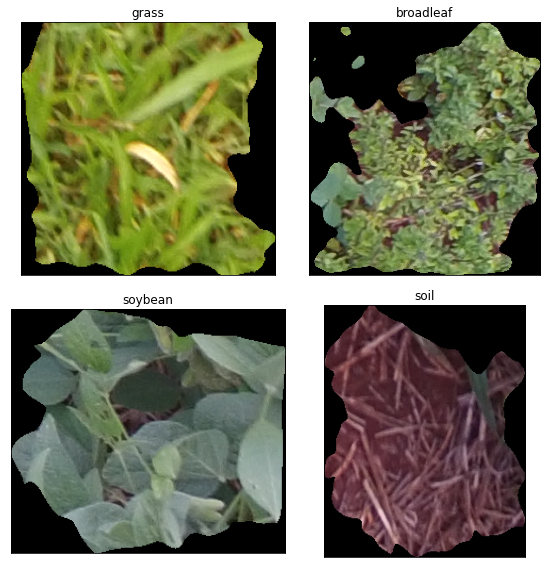

In [18]:
#Viewing some of the images in the dataframe
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(imageio.imread(final_data.Images[i]))
    ax.set_title(final_data.Labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Data Augmentations
> For EfficientNet-B1 the input image size used is (240, 240, 3)

- Horizontal Flipping
- Shearing
- Scaling
- Translation
- Rotation
- Brightness Shift

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet

train_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input,
    validation_split = 0.1
)

test_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input
)

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final_data, train_size=0.7, shuffle=True, random_state=42, stratify=final_data[["Labels"]])

train = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(240, 240),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    fill_mode="nearest"
)

validation = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(240, 240),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5,1.5],
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test = test_generator_eff_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(240, 240),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 26302 validated image filenames belonging to 16 classes.
Found 2922 validated image filenames belonging to 16 classes.
Found 12526 validated image filenames belonging to 16 classes.


# Building the Model

## [EffcientNet](https://arxiv.org/abs/1905.11946)

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients. For example, if we want to use `2^N` times more computational resources, then we can simply increase the network depth by `α^N`, width by `β^N`, and image size by `γ^N`, where  are constant coefficients determined by a small grid search on the original small model. EfficientNet uses a compound coefficient  to uniformly scales network width, depth, and resolution in a principled way.

In [12]:
basemodel = efficientnet.EfficientNetB0(
                                          include_top=False,
                                          weights='imagenet',
                                          input_shape=(240,240,3), 
                                          pooling='avg',
                                        )
# basemodel.summary()
basemodel.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(256, activation='relu')(basemodel.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(16, activation='softmax')(x)

efficientnet = Model(inputs=basemodel.inputs, outputs=outputs)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [15]:
efficientnet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [17]:
CHECKPOINTS = Path("./checkpoints")
CHECKPOINTS.mkdir(exist_ok=True)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

with tf.device('/GPU:0'):
# training
    results = efficientnet.fit(
        train,
        validation_data = validation,
        batch_size = 32,
        epochs = 10,
        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=4,
                restore_best_weights=True
            ), 
            ReduceLROnPlateau(patience=2),
            ModelCheckpoint(
                str(CHECKPOINTS),
                monitor="val_loss",
                save_best_only=True
            ),
        ]
    )

Epoch 1/10
822/822 [==============================] - 361s 426ms/step - loss: 0.3495 - categorical_accuracy: 0.8853 - val_loss: 0.1565 - val_categorical_accuracy: 0.9490


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
822/822 [==============================] - 192s 233ms/step - loss: 0.1642 - categorical_accuracy: 0.9447 - val_loss: 0.1078 - val_categorical_accuracy: 0.9627


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
822/822 [==============================] - 191s 233ms/step - loss: 0.1273 - categorical_accuracy: 0.9556 - val_loss: 0.1144 - val_categorical_accuracy: 0.9559
Epoch 4/10
822/822 [==============================] - 192s 233ms/step - loss: 0.1123 - categorical_accuracy: 0.9624 - val_loss: 0.0878 - val_categorical_accuracy: 0.9692


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
822/822 [==============================] - 197s 240ms/step - loss: 0.0962 - categorical_accuracy: 0.9681 - val_loss: 0.0995 - val_categorical_accuracy: 0.9699
Epoch 6/10
822/822 [==============================] - 191s 232ms/step - loss: 0.0888 - categorical_accuracy: 0.9702 - val_loss: 0.0907 - val_categorical_accuracy: 0.9730
Epoch 7/10
822/822 [==============================] - 190s 231ms/step - loss: 0.0505 - categorical_accuracy: 0.9833 - val_loss: 0.0542 - val_categorical_accuracy: 0.9829


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/10
822/822 [==============================] - 195s 237ms/step - loss: 0.0456 - categorical_accuracy: 0.9844 - val_loss: 0.0531 - val_categorical_accuracy: 0.9843


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/10
822/822 [==============================] - 198s 241ms/step - loss: 0.0411 - categorical_accuracy: 0.9859 - val_loss: 0.0532 - val_categorical_accuracy: 0.9815
Epoch 10/10
822/822 [==============================] - 194s 236ms/step - loss: 0.0425 - categorical_accuracy: 0.9853 - val_loss: 0.0517 - val_categorical_accuracy: 0.9832


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


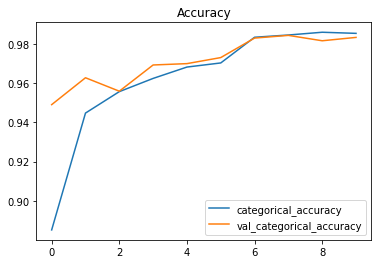

In [19]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

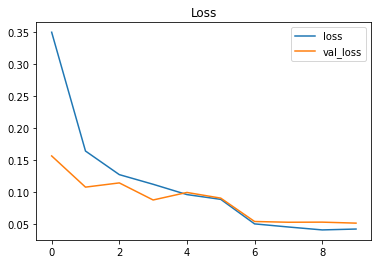

In [20]:
pd.DataFrame(results.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [21]:
efficientnet.save('kevin_efficientnet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
# dump the training history as well
np.save('efficient_model_history.npy', results.history)

# history=np.load('model_history.npy',allow_pickle='TRUE').item()

# Model Evaluation

In [23]:
# Testing the model
results = efficientnet.evaluate(test)

392/392 [==============================] - 164s 418ms/step - loss: 0.0448 - categorical_accuracy: 0.9848


In [24]:
predictions = np.argmax(efficientnet.predict(test), axis=1)

### Classification Report

In [25]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

                           precision    recall  f1-score   support

              Black-grass       0.87      0.69      0.77       185
                 Charlock       1.00      0.99      0.99       271
                 Cleavers       0.99      0.99      0.99       201
         Common Chickweed       0.94      0.99      0.96       428
             Common wheat       0.96      0.96      0.96       152
                  Fat Hen       0.97      0.95      0.96       323
         Loose Silky-bent       0.88      0.95      0.92       457
                    Maize       0.99      0.99      0.99       154
        Scentless Mayweed       0.94      0.93      0.94       364
         Shepherd’s Purse       0.93      0.82      0.87       164
Small-flowered Cranesbill       0.97      0.99      0.98       346
               Sugar beet       0.96      0.97      0.97       278
                broadleaf       0.99      0.99      0.99       715
                    grass       1.00      1.00      1.00     

### Confusion Matrix

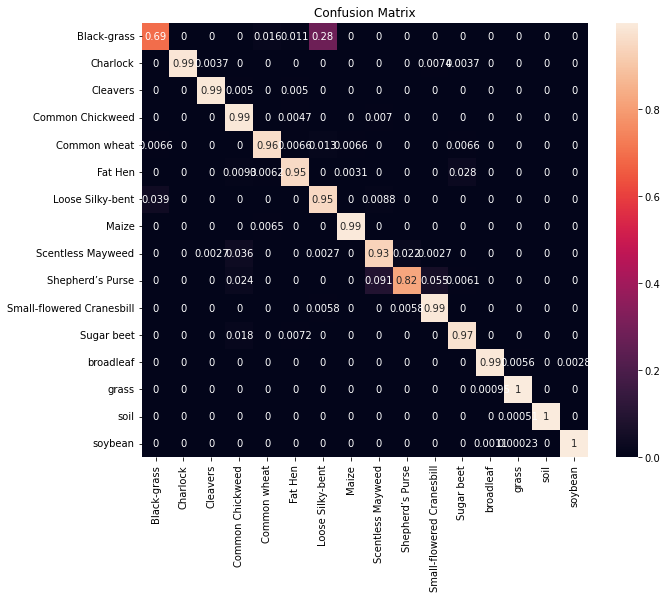

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()